#Mount Gdrive

In [ ]:
#Mounting my Google Drive to get access to the data files
from google.colab import drive
drive.mount('/content/gdrive/')

# Create a symbolic link
!ln -s /content/gdrive/MyDrive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive/
Data  yolov3  yolov3-tiny  yolov4


#Clone and setup darknet repository

In [ ]:
# Clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

# Change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

# Make darknet (build)
!make

#Load dataset

In [ ]:
%cd data
#loading the training dataset
!unzip -q '/mydrive/Data/obj.zip'
#loading the test dataset
!unzip -q '/mydrive/Data/test.zip'
%cd ..

/content/darknet/data
/content/darknet


In [ ]:
# Define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

#Custom training files

In [ ]:
#Copy customized files from gdrive
!cp /mydrive/yolov3-tiny/obj.names /content/darknet/data/
!cp /mydrive/yolov3-tiny/obj.data /content/darknet/data/
!cp /mydrive/yolov3-tiny/yolov3-tiny_3l_custom.cfg /content/darknet/cfg/
!cp /mydrive/yolov3-tiny/generate_train.py /content/darknet/
!cp /mydrive/yolov3-tiny/generate_test.py /content/darknet/

In [ ]:
#Script to generate the paths for training and test images
!python generate_train.py
!python generate_test.py

#YOLO training

In [ ]:
# Download pretrained convolutional layer weights (Run only when trianing for the first time)
!wget http://pjreddie.com/media/files/darknet53.conv.74

# train your custom detector  (Run only when trianing for the first time)
!./darknet detector train data/obj.data cfg/yolov3-tiny_3l_custom.cfg darknet53.conv.74 -dont_show

--2021-08-09 07:23:55--  http://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/darknet53.conv.74 [following]
--2021-08-09 07:23:55--  https://pjreddie.com/media/files/darknet53.conv.74
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  59.5MB/s    in 2.6s    

2021-08-09 07:23:57 (59.5 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



In [ ]:
#Incase training got interrupted resume from the last checkpoint instead of training from start
!./darknet detector train data/obj.data cfg/yolov3-tiny_3l_custom.cfg /mydrive/yolov3-tiny/backup/yolov3-tiny_3l_last.weights -dont_show

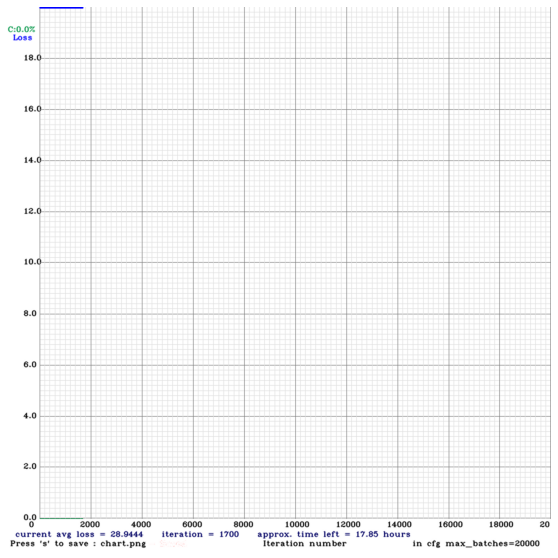

In [ ]:
#Show learning curve
imShow('chart.png')

#Model evaluation

In [ ]:
#Calculate the Mean Average Precis
!./darknet detector map data/obj.data cfg/yolov3-tiny_3l_custom.cfg /mydrive/yolov3-tiny/backup/yolov3-tiny_3l_custom_last.weights

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256   

#Model Inference

In [ ]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov3-tiny_3l_custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3-tiny_3l_custom.cfg
%cd ..

/content/darknet/cfg
/content/darknet


##Image

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256    

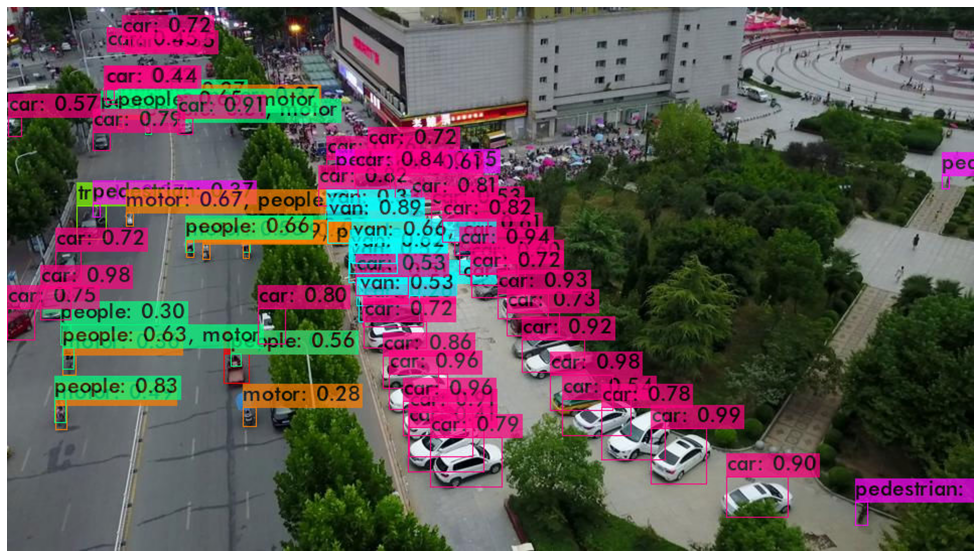

In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector test data/obj.data cfg/yolov3-tiny_3l_custom.cfg /mydrive/yolov3-tiny/backup/yolov3-tiny_3l_custom_last.weights /mydrive/Data/test1.jpg
imShow('predictions.jpg')

##Video

In [ ]:
#Test the algorithm on video file
!./darknet detector demo data/obj.data cfg/yolov3-tiny_3l_custom.cfg /mydrive/yolov3-tiny/backup/yolov3-tiny_3l_custom_last.weights -dont_show -ext_output /mydrive/Data/vid_2.mp4 -i 0 -out_filename custom_res.mp4

Streaming output truncated to the last 5000 lines.
car: 38% , van: 42% 	(left_x:  779   top_y:   69   width:   79   height:   37)
car: 58% , van: 40% 	(left_x:  921   top_y:  297   width:   68   height:   89)
car: 29% , van: 35% 	(left_x:  838   top_y:   35   width:   37   height:   33)
van: 30% 	(left_x: 1306   top_y:  287   width:  123   height:   68)
car: 99% 	(left_x:  255   top_y:  659   width:  301   height:  148)
car: 98% 	(left_x: 1312   top_y:  241   width:  129   height:   56)
car: 93% 	(left_x:  940   top_y:  175   width:   52   height:   56)
car: 90% 	(left_x:  896   top_y:   42   width:   37   height:   31)
car: 90% 	(left_x: 1226   top_y:  336   width:   76   height:   69)
car: 87% 	(left_x:  747   top_y:  114   width:   71   height:   40)
car: 86% 	(left_x:  963   top_y:   98   width:   40   height:   37)
car: 78% 	(left_x: 1047   top_y:  117   width:   38   height:   39)
car: 70% 	(left_x: 1147   top_y:   36   width:   48   height:   28)
car: 54% 	(left_x: 1124   top_y:

In [ ]:
#Download the output video
download('custom_res.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>